In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import splu

from scipy.special import gammaincc, gamma, gammainc, expi

def potential_theoretical_gaussian(X, Y, sigma):
    # Constants
    pi = np.pi
    r = np.sqrt(X**2 + Y**2)
    # Calculate the potential
    term1 = -1 / (2 * pi) * np.log(r)
    # term2 = -1 / (2 * pi) * 0.5 * gammaincc(0, r**2 / (2 * sigma**2))
    term2 = -1 / (2 * pi) * 0.5 * (-expi(-r**2 / (2 * sigma**2)))

    return term1 + term2

def assemble_poisson_matrix_noperm(nrows, ncols, hx, hy):
    A = lil_matrix((nrows * ncols, nrows * ncols))

    for i in range(nrows):
        for j in range(ncols):
            k = i * ncols + j

            if i == 0 or i == nrows - 1 or j == 0 or j == ncols - 1:
                A[k, k] = 1  # Modify diagonal for Dirichlet BC
                continue

            A[k, k] = -2 / hx**2 - 2 / hy**2
            
            # if j + 1 < ncols:
            A[k, k + 1] = 1 / hx**2

            # if j - 1 >= 0:
            A[k, k - 1] = 1 / hx**2

            # if i + 1 < nrows:
            A[k, k + ncols] = 1 / hy**2

            # if i - 1 >= 0:
            A[k, k - ncols] = 1 / hy**2

    A = A.tocsc()
    lu_A = splu(A)

    return lu_A

In [6]:
def assemble_poisson_matrix(nrows, ncols, hx, hy, eps_in):
    A = lil_matrix((nrows * ncols, nrows * ncols))
    eps = eps_in.ravel()[:]
    for i in range(nrows):
        for j in range(ncols):
            k = i * ncols + j

            if i == 0 or i == nrows - 1 or j == 0 or j == ncols - 1:
                A[k, k] = 1  # Modify diagonal for Dirichlet BC
                continue

            A[k, k] = - 0.5 * (eps[k-1] + eps[k+1] + 2 * eps[k]) / hx**2  - 0.5 * (eps[k-ncols] + eps[k+ncols] + 2 * eps[k]) / hy**2
            
            # if j + 1 < ncols:
            A[k, k + 1] = 1 / hx**2 * (eps[k] + eps[k+1]) * 0.5

            # if j - 1 >= 0:
            A[k, k - 1] = 1 / hx**2 * (eps[k] + eps[k-1]) * 0.5

            # if i + 1 < nrows:
            A[k, k + ncols] = 1 / hy**2 * (eps[k] + eps[k+ncols]) * 0.5

            # if i - 1 >= 0:
            A[k, k - ncols] = 1 / hy**2 * (eps[k] + eps[k-ncols]) * 0.5

    A = A.tocsc()
    lu_A = splu(A)

    return lu_A

In [ ]:
%matplotlib inline

xmin = -10
xmax = 10
ymin = -20
ymax = 20
npx = 100
npy = 200

x = np.linspace(xmin, xmax, npx)
y = np.linspace(ymin, ymax, npy)

hx = x[2] - x[1]
hy = y[2] - y[1]

X, Y = np.meshgrid(x, y)
eps = np.ones_like(X)
eps[X > 0] *= 12


nrows, ncols = np.shape(X) 
lu_a = assemble_poisson_matrix(nrows, ncols, hx, hy, eps)



In [8]:

sigma = 0.5
rho = np.exp(-((X-5)**2 + Y**2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
rho[X<0] = 0
rho[:,0] = 0
rho[0,:] = 0
rho[-1,:] = 0
rho[:,-1] = 0

b = -rho.ravel()[:]

phi = lu_a.solve(b)
phi = phi.reshape(X.shape)

phi_theory = potential_theoretical_gaussian(X, Y, sigma)

Ey, Ex = np.gradient(-phi, hy, hx)
Ey_theory, Ex_theory = np.gradient(-phi_theory, hy, hx)



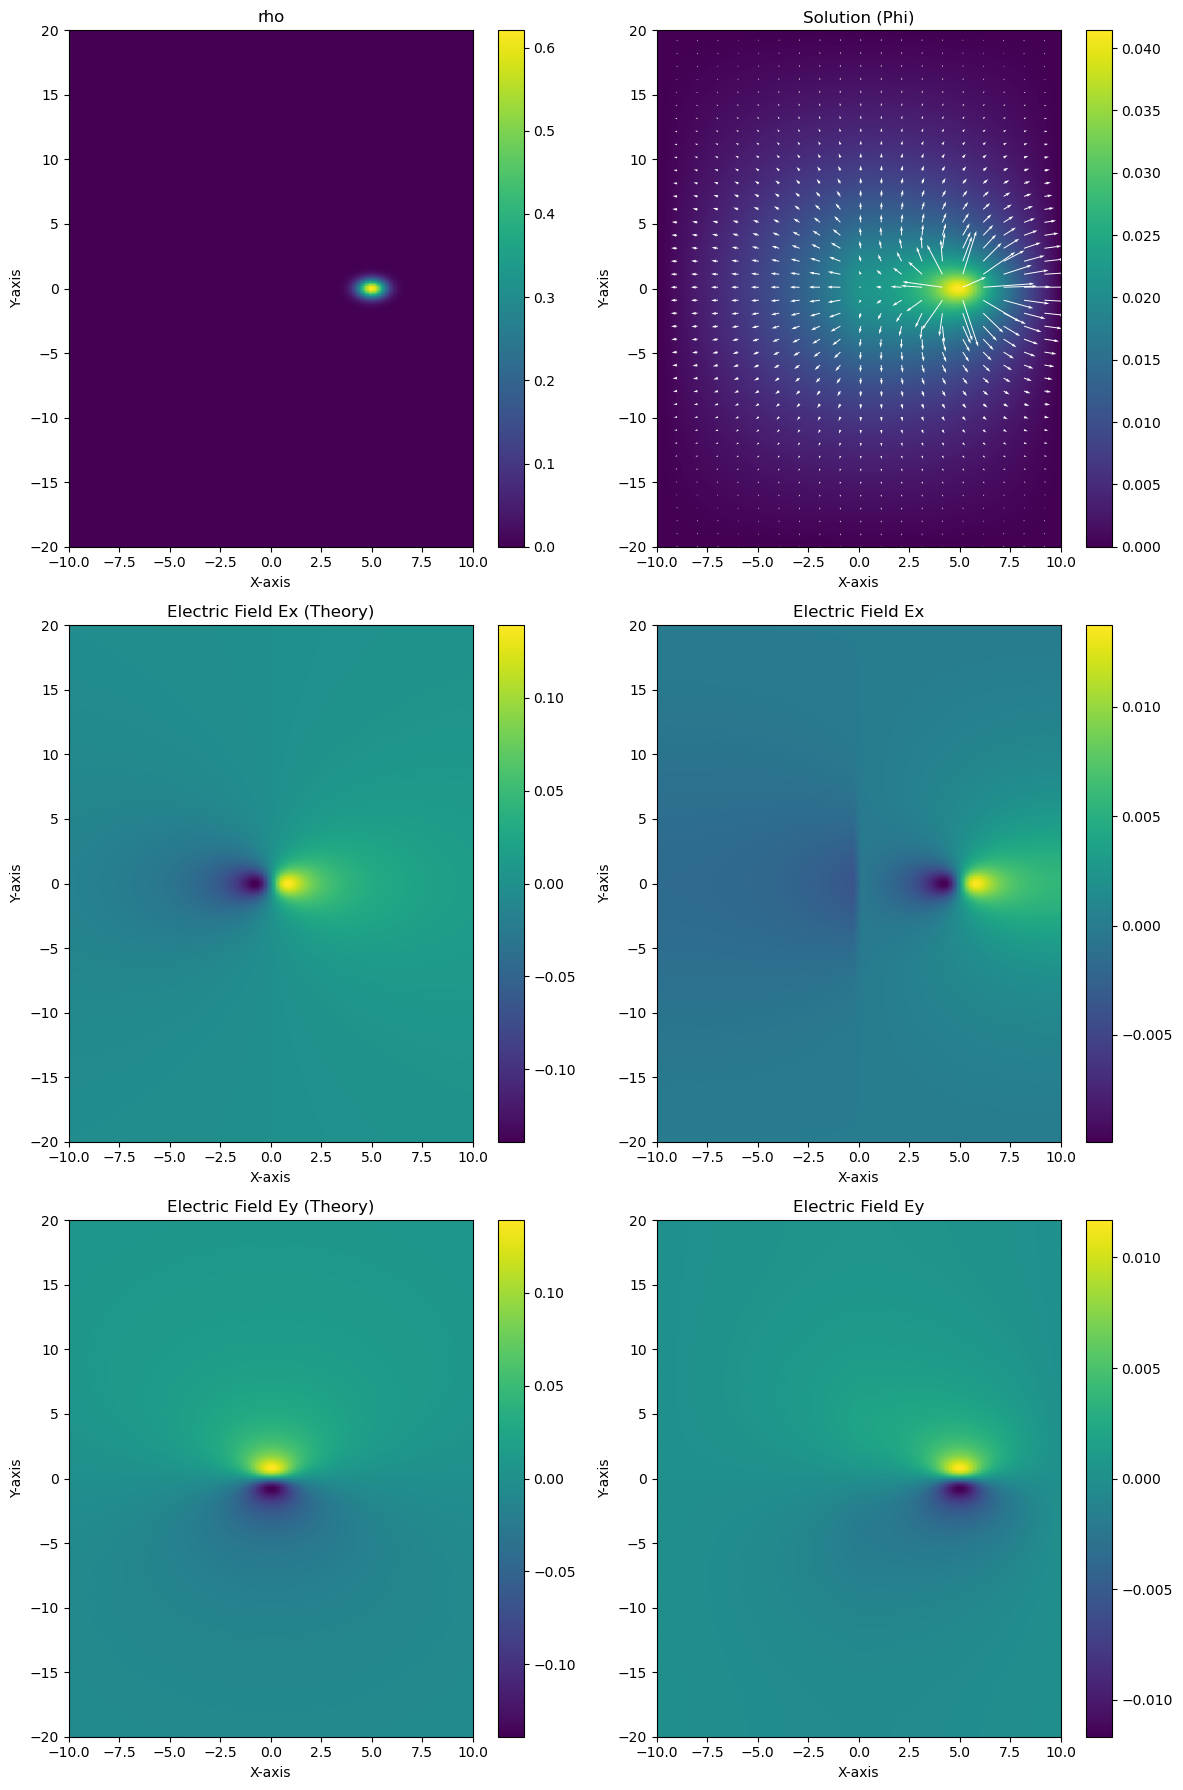

In [229]:
%matplotlib inline
step = 5
# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Plot phi_theory
c1 = axs[0, 0].imshow(rho, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[0, 0].set_title('rho')
axs[0, 0].set_xlabel('X-axis')
axs[0, 0].set_ylabel('Y-axis')
fig.colorbar(c1, ax=axs[0, 0])

# Plot phi
c2 = axs[0, 1].imshow(phi, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[0, 1].quiver(X[::step, ::step], Y[::step, ::step], Ex[::step, ::step], Ey[::step, ::step], 
                 color='white', scale=.1)
axs[0, 1].set_title('Solution (Phi)')
axs[0, 1].set_xlabel('X-axis')
axs[0, 1].set_ylabel('Y-axis')
fig.colorbar(c2, ax=axs[0, 1])

# Plot Ex_theory
c3 = axs[1, 0].imshow(Ex_theory, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[1, 0].set_title('Electric Field Ex (Theory)')
axs[1, 0].set_xlabel('X-axis')
axs[1, 0].set_ylabel('Y-axis')
fig.colorbar(c3, ax=axs[1, 0])

# Plot Ex
c4 = axs[1, 1].imshow(Ex, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[1, 1].set_title('Electric Field Ex')
axs[1, 1].set_xlabel('X-axis')
axs[1, 1].set_ylabel('Y-axis')
fig.colorbar(c4, ax=axs[1, 1])

# Plot Ey_theory
c5 = axs[2, 0].imshow(Ey_theory, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[2, 0].set_title('Electric Field Ey (Theory)')
axs[2, 0].set_xlabel('X-axis')
axs[2, 0].set_ylabel('Y-axis')
fig.colorbar(c5, ax=axs[2, 0])

# Plot Ey
c6 = axs[2, 1].imshow(Ey, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs[2, 1].set_title('Electric Field Ey')
axs[2, 1].set_xlabel('X-axis')
axs[2, 1].set_ylabel('Y-axis')
fig.colorbar(c6, ax=axs[2, 1])

plt.tight_layout()
plt.show()


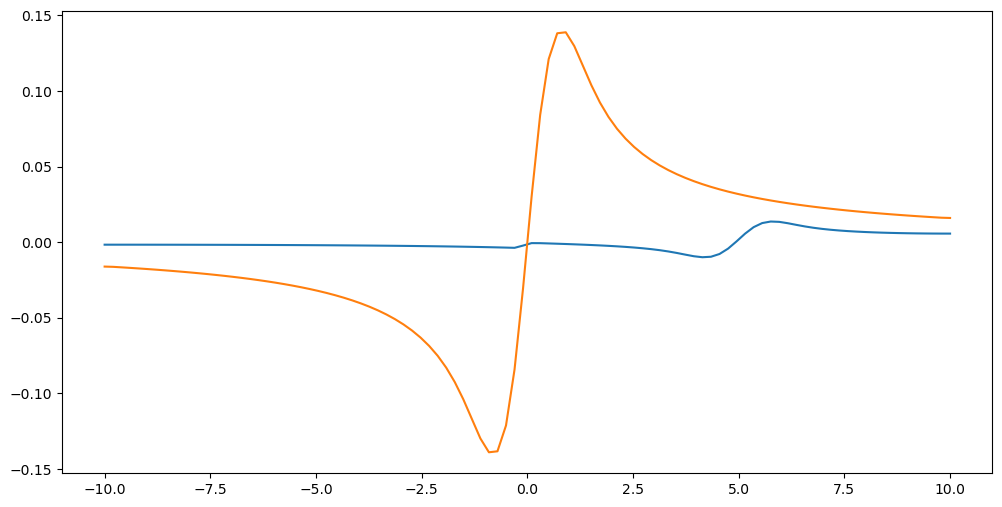

In [230]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x, Ex[nrows//2, :])
plt.plot(x, Ex_theory[nrows//2, :])


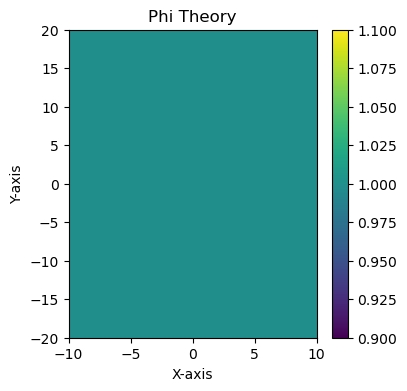

In [315]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4 ))

# Plot phi_theory
c1 = axs.imshow(eps, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect = 'auto')
axs.set_title('Phi Theory')
axs.set_xlabel('X-axis')
axs.set_ylabel('Y-axis')
fig.colorbar(c1, ax=axs)

In [2]:
def assemble_poisson_matrix_radial(nrows, ncols, hx, hR, eps_in, R):
    A = lil_matrix((nrows * ncols, nrows * ncols))
    eps = eps_in.ravel()[:]
    epsR = (eps_in * R).ravel()[:]
    Ri = R.ravel()[:]

    


    for i in range(1,nrows-1):
        for j in range(1,ncols-1):
            k = i * ncols + j

            A[k, k] = - 0.5 * (eps[k-1] + eps[k+1] + 2 * eps[k]) / hx**2  
            - 0.5 * (epsR[k-ncols] + epsR[k+ncols] + 2 * epsR[k]) / hR**2 / Ri[k]
            
            # if j + 1 < ncols:
            A[k, k + 1] = 1 / hx**2 * (eps[k] + eps[k+1]) * 0.5

            # if j - 1 >= 0:
            A[k, k - 1] = 1 / hx**2 * (eps[k] + eps[k-1]) * 0.5

            # if i + 1 < nrows:
            A[k, k + ncols] = 1 / hR**2 * (epsR[k] + epsR[k+ncols]) * 0.5 / Ri[k]

            # if i - 1 >= 0:
            A[k, k - ncols] = 1 / hR**2 * (epsR[k] + epsR[k-ncols]) * 0.5 / Ri[k]

    for i in range(nrows):
        for j in range(ncols):
            k = i * ncols + j

            # Neumann BC at z = 0 (top boundary)
            if i == 0:
                A[k, k] = -1
                if k + ncols < A.shape[1]:  # Ensure we're within bounds
                    A[k, k + ncols] = 1  # Set value equal to its neighbor to ensure zero flux

            # Neumann BC at z = max (bottom boundary)
            elif i == nrows - 1:
                A[k, k] = 1
                # if k - ncols >= 0:  # Ensure we're within bounds
                #     A[k, k - ncols] = -1  # Set value equal to its neighbor to ensure zero flux

            # Neumann BC at r = 0 (left boundary)
            elif j == 0:
                A[k, k] = 1
                # if k + 1 < A.shape[1]:  # Ensure we're within bounds
                #     A[k, k + 1] = -1  # Set value equal to its neighbor to ensure zero flux

            # Neumann BC at r = max (right boundary)
            elif j == ncols - 1:
                A[k, k] = 1
                # if k - 1 >= 0:  # Ensure we're within bounds
                #     A[k, k - 1] = -1  # Set value equal to its neighbor to ensure zero flux





    A = A.tocsc()
    lu_A = splu(A)

    return lu_A

In [3]:
# def assemble_poisson_matrix_cartesian_with_neumann(nrows, ncols, hx, hy, eps_in):
#     A = lil_matrix((nrows * ncols, nrows * ncols))
#     eps = eps_in.ravel()[:]
#     for i in range(1,nrows-1):
#         for j in range(1,ncols-1):
#             k = i * ncols + j

#             # if i == 0 or i == nrows - 1 or j == 0 or j == ncols - 1:
#             #     A[k, k] = 1  # Modify diagonal for Dirichlet BC
#             #     continue

#             A[k, k] = - 0.5 * (eps[k-1] + eps[k+1] + 2 * eps[k]) / hx**2  - 0.5 * (eps[k-ncols] + eps[k+ncols] + 2 * eps[k]) / hy**2
            
#             # if j + 1 < ncols:
#             A[k, k + 1] = 1 / hx**2 * (eps[k] + eps[k+1]) * 0.5

#             # if j - 1 >= 0:
#             A[k, k - 1] = 1 / hx**2 * (eps[k] + eps[k-1]) * 0.5

#             # if i + 1 < nrows:
#             A[k, k + ncols] = 1 / hy**2 * (eps[k] + eps[k+ncols]) * 0.5

#             # if i - 1 >= 0:
#             A[k, k - ncols] = 1 / hy**2 * (eps[k] + eps[k-ncols]) * 0.5

        
#     for i in range(nrows):
#         for j in range(ncols):
#             k = i * ncols + j

#             # Neumann BC at z = 0 (top boundary)
#             if i == 0:
#                 # A[k, k] = 1
                # if k + ncols < A.shape[0]:  # Ensure we're within bounds
                #     A[k, k + ncols] = -1  # Set value equal to its neighbor to ensure zero flux

#             # Neumann BC at z = max (bottom boundary)
#             elif i == nrows - 1:
#                 A[k, k] = 1


#             # Neumann BC at r = 0 (left boundary)
#             elif j == 0:
#                 A[k, k] = 1

#             # Neumann BC at r = max (right boundary)
#             elif j == ncols - 1:
#                 A[k, k] = 1


#     A = A.tocsc()
#     lu_A = splu(A)

#     return lu_A

In [4]:
%matplotlib inline

zmin = -100
zmax = 100
rmin = 0
rmax = 100
npz = 100
npr = 300

z = np.linspace(zmin, zmax, npz)
r = np.linspace(rmin, rmax, npr)

hz = z[1] - z[0]
hr = r[1] - r[0]


Z, R = np.meshgrid(z, r)
eps = np.ones_like(Z)
# eps[Z > 0] *= 12


nrows, ncols = np.shape(Z) 

lu_a = assemble_poisson_matrix_radial(nrows, ncols, hz, hr, eps, R)
# lu_a = assemble_poisson_matrix_cartesian_with_neumann(nrows, ncols, hz, hr, eps)



NameError: name 'lil_matrix' is not defined

In [ ]:
from scipy.special import erf

def compute_expression_ezr_theoretical(z, r, sigma):
    sqrt_rz = np.sqrt(r**2 + z**2)
    exp_term = -np.exp(-(r**2 + z**2) / (2 * sigma**2)) * np.sqrt(2 / np.pi)
    erf_term = sigma * erf(sqrt_rz / (np.sqrt(2) * sigma))
    numerator = exp_term * sqrt_rz + erf_term
    denominator = 4 * np.pi * sigma * sqrt_rz * (r**2 + z**2)
    ez = numerator * (z / denominator)
    er = numerator * (r / denominator)
    
    return ez, er

In [ ]:
sigma = 10
rho = np.exp(-((R)**2 + (Z)**2) / (2 * sigma ** 2)) / (2 * np.sqrt(2) * np.pi**(3/2) * sigma**3) * 2 * np.pi

rho[:,0] = 0
rho[:,-1] = 0

rho[0,:] = 0
rho[-1,:] = 0

b = -rho.ravel()[:]

phi = lu_a.solve(b)
phi = phi.reshape(Z.shape)



Er, Ez = np.gradient(-phi, -hr, hz)



Ez_theory , Er_theory = compute_expression_ezr_theoretical(Z, R, sigma)

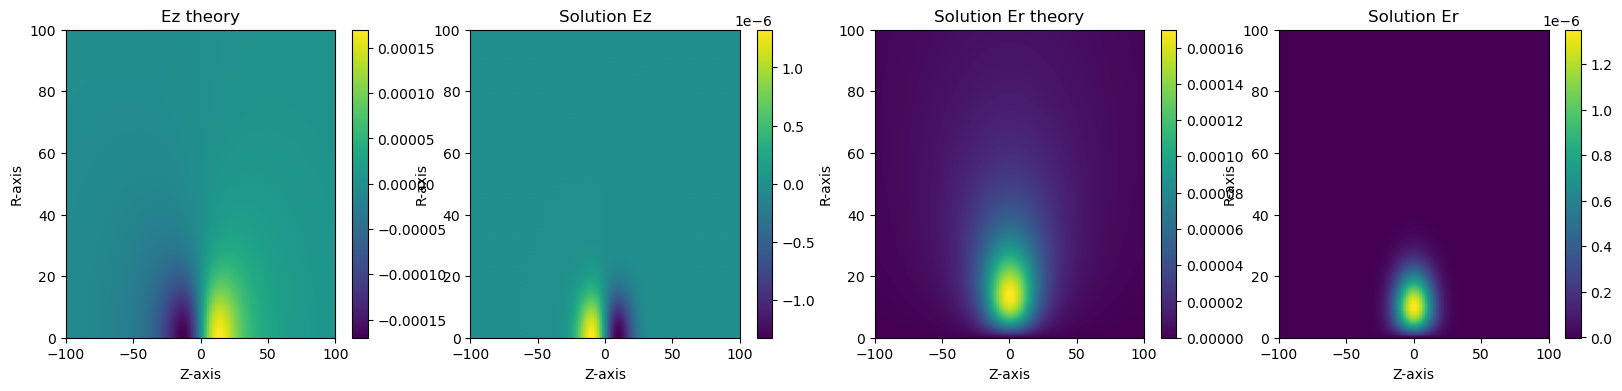

In [ ]:

%matplotlib inline
step = 10
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
# Plot phi
c0 = axs[0].imshow(Ez_theory, extent=(zmin, zmax, rmin, rmax), origin='lower', cmap='viridis', aspect = 'auto')
axs[0].set_title('Ez theory')
axs[0].set_xlabel('Z-axis')
axs[0].set_ylabel('R-axis')
fig.colorbar(c0, ax=axs[0])


c1 = axs[1].imshow(Ez, extent=(zmin, zmax, rmin, rmax), origin='lower', cmap='viridis', aspect = 'auto')
axs[1].set_title('Solution Ez')
axs[1].set_xlabel('Z-axis')
axs[1].set_ylabel('R-axis')
fig.colorbar(c1, ax=axs[1])

c2 = axs[2].imshow(Er_theory, extent=(zmin, zmax, rmin, rmax), origin='lower', cmap='viridis', aspect = 'auto')
axs[2].set_title('Solution Er theory')
axs[2].set_xlabel('Z-axis')
axs[2].set_ylabel('R-axis')
fig.colorbar(c2, ax=axs[2])

c3 = axs[3].imshow(Er, extent=(zmin, zmax, rmin, rmax), origin='lower', cmap='viridis', aspect = 'auto')
axs[3].set_title('Solution Er')
axs[3].set_xlabel('Z-axis')
axs[3].set_ylabel('R-axis')
fig.colorbar(c3, ax=axs[3])



In [3]:
# Define thresholds in descending order (threshold, value)
thresholds = [
    (1e11, 50),
    (1e8, 20),
    (1e7, 5),
    (1e6, 5),
    (1e3, 1)
]

# Set default value for Lx if no threshold is met
Lx = None
nc = 1e3
# Iterate through thresholds and find the appropriate value for Lx
for threshold, value in thresholds:
    if nc < threshold:
        Lx = value
        break  # Exit the loop once the correct threshold is found

# Optionally handle cases where nc exceeds all thresholds
if Lx is None:
    Lx = 50  # or some default/fallback value

Lx

50

In [ ]:
def poisson_solver_traditional(n_e, n_h, x, y, epsilon_0, phi, tol, max_iter, eps):
    qe = 1.6e-19
    rho = qe * (n_e - n_h)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    V = phi.copy()
    V[:, 0] = 0
    V[:, -1] = 0
    V[0, :] = 0
    V[-1, :] = 0
    for iter in range(max_iter):
        V_old = V.copy()
        epsilon_y1 = (eps[1:-1, 1:-1] + eps[2:, 1:-1]) / 2
        epsilon_y2 = (eps[1:-1, 1:-1] + eps[:-2, 1:-1]) / 2
        epsilon_x1 = (eps[1:-1, 1:-1] + eps[1:-1, 2:]) / 2
        epsilon_x2 = (eps[1:-1, 1:-1] + eps[1:-1, :-2]) / 2
        denominator = (epsilon_x1 / dx**2 + epsilon_x2 / dx**2 + epsilon_y1 / dy**2 + epsilon_y2 / dy**2)
        V[1:-1, 1:-1] = (1 / denominator) * (
            epsilon_y1 * V[2:, 1:-1] / dy**2 +
            epsilon_y2 * V[:-2, 1:-1] / dy**2 +
            epsilon_x1 * V[1:-1, 2:] / dx**2 +
            epsilon_x2 * V[1:-1, :-2] / dx**2 +
            rho[1:-1, 1:-1] / epsilon_0
        )
        if np.max(np.abs(V - V_old)) < tol:
            break
    E_y, E_x = np.gradient(-V, dy, dx)
    return E_x, E_y, V, True

In [3]:
def assemble_poisson_matrix_neumann(nrows, ncols, hx, hy, eps_in):
    A = lil_matrix((nrows * ncols, nrows * ncols))
    eps = eps_in.ravel()[:]
    for i in range(0,nrows):
        for j in range(0,ncols):
            k = i * ncols + j


            if j == 0 and (i != 0 and i != nrows - 1):
                A[k, k] = -0.5 * (eps[k+1] + eps[k+1] + 2 * eps[k]) / hx**2 - 0.5 * (eps[k-ncols] + eps[k+ncols] + 2 * eps[k]) / hy**2
                A[k, k + 1] = 2 / hx**2 * (eps[k] + eps[k+1]) * 0.5
                A[k, k + ncols] = 1 / hy**2 * (eps[k] + eps[k+ncols]) * 0.5
                A[k, k - ncols] = 1 / hy**2 * (eps[k] + eps[k-ncols]) * 0.5
                continue

            if (i == 0 or i == nrows - 1 or j == ncols - 1):
                A[k, k] = 1
                continue
                
            A[k, k] = -0.5 * (eps[k-1] + eps[k+1] + 2 * eps[k]) / hx**2 - 0.5 * (eps[k-ncols] + eps[k+ncols] + 2 * eps[k]) / hy**2
            A[k, k + 1] = 1 / hx**2 * (eps[k] + eps[k+1]) * 0.5
            A[k, k - 1] = 1 / hx**2 * (eps[k] + eps[k-1]) * 0.5
            A[k, k + ncols] = 1 / hy**2 * (eps[k] + eps[k+ncols]) * 0.5
            A[k, k - ncols] = 1 / hy**2 * (eps[k] + eps[k-ncols]) * 0.5


    A = A.tocsc()
    lu_A = splu(A)
    return lu_A, A

In [69]:
xmin = 0
xmax = 100
ymin = -100
ymax = 100
npx = 1000
npy = 100

x = np.linspace(xmin, xmax, npx)
y = np.linspace(ymin, ymax, npy)

hx = x[2] - x[1]
hy = y[2] - y[1]

X, Y = np.meshgrid(x, y)
eps = np.ones_like(X) * 12
# eps[X > 0] *= 12


nrows, ncols = np.shape(X) 
lu_a, A = assemble_poisson_matrix_neumann(nrows, ncols, hx, hy, eps)

In [70]:

sigma = 40 / np.sqrt(8 * np.log(2))
alpha = 7

rho1 = np.exp(-alpha * (X))  * np.exp(-(Y**2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2) * 4e10
# rho[X<0] = 0

rho1[:,0] = 0 # Left boundary
rho1[:,-1] = 0 # Right boundary

rho1[0,:] = 0  # Bottom boundary
rho1[-1,:] = 0 # Top boundary

b1 = -rho1.ravel()[:]

phi1 = lu_a.solve(b1)
phi1 = phi1.reshape(X.shape)

rho2 = np.exp(-alpha * (X))  * np.exp(-(Y**2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2) * 4

rho2[:,0] = 0 # Left boundary
rho2[:,-1] = 0 # Right boundary

rho2[0,:] = 0  # Bottom boundary
rho2[-1,:] = 0 # Top boundary


b2 = -rho2.ravel()[:]

phi2 = lu_a.solve(b2)
phi2 = phi2.reshape(X.shape)


# phi_theory = potential_theoretical_gaussian(X, Y, sigma)

Ey1, Ex1 = np.gradient(-phi1, hy, hx)
Ey2, Ex2 = np.gradient(-phi2, hy, hx)



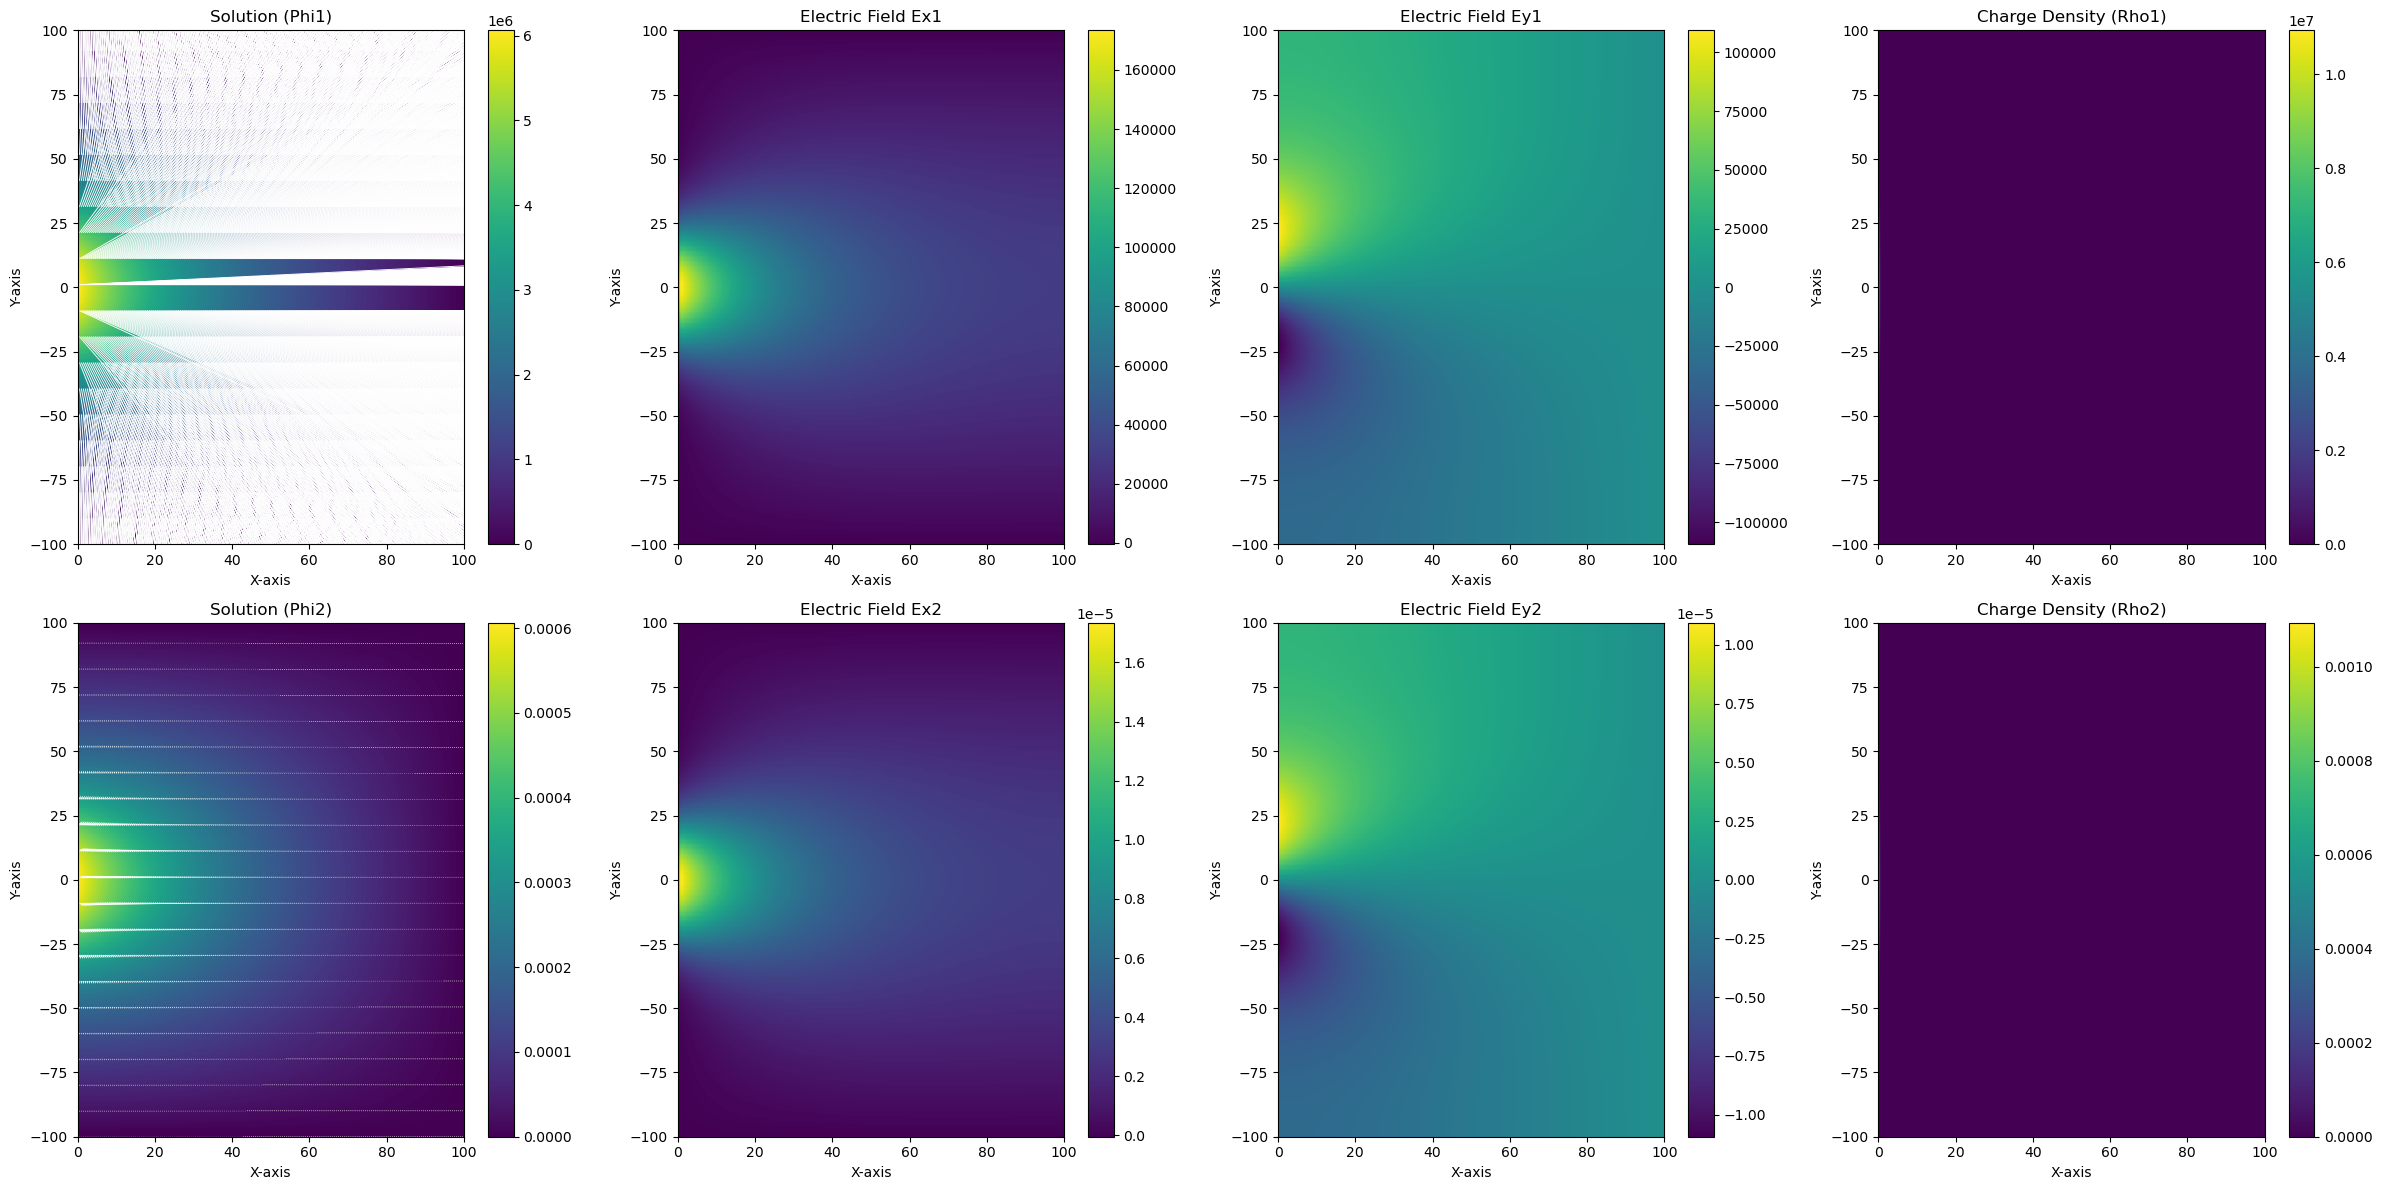

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

step = 5
# Create a 2x4 grid of subplots
fig, axs = plt.subplots(2, 4, figsize=(24, 12))

# Plot phi1
c1 = axs[0, 0].imshow(phi1, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect='auto')
axs[0, 0].quiver(X[::step, ::step], Y[::step, ::step], Ex1[::step, ::step], Ey1[::step, ::step], 
                 color='white', scale=.001)
axs[0, 0].set_title('Solution (Phi1)')
axs[0, 0].set_xlabel('X-axis')
axs[0, 0].set_ylabel('Y-axis')
fig.colorbar(c1, ax=axs[0, 0])

# Plot Ex1
c2 = axs[0, 1].imshow(Ex1, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect='auto')
axs[0, 1].set_title('Electric Field Ex1')
axs[0, 1].set_xlabel('X-axis')
axs[0, 1].set_ylabel('Y-axis')
fig.colorbar(c2, ax=axs[0, 1])

# Plot Ey1
c3 = axs[0, 2].imshow(Ey1, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect='auto')
axs[0, 2].set_title('Electric Field Ey1')
axs[0, 2].set_xlabel('X-axis')
axs[0, 2].set_ylabel('Y-axis')
fig.colorbar(c3, ax=axs[0, 2])

# Plot rho1
c4 = axs[0, 3].imshow(rho1, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect='auto')
axs[0, 3].set_title('Charge Density (Rho1)')
axs[0, 3].set_xlabel('X-axis')
axs[0, 3].set_ylabel('Y-axis')
fig.colorbar(c4, ax=axs[0, 3])

# Plot phi2
c5 = axs[1, 0].imshow(phi2, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect='auto')
axs[1, 0].quiver(X[::step, ::step], Y[::step, ::step], Ex2[::step, ::step], Ey2[::step, ::step], 
                 color='white', scale=.001)
axs[1, 0].set_title('Solution (Phi2)')
axs[1, 0].set_xlabel('X-axis')
axs[1, 0].set_ylabel('Y-axis')
fig.colorbar(c5, ax=axs[1, 0])

# Plot Ex2
c6 = axs[1, 1].imshow(Ex2, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect='auto')
axs[1, 1].set_title('Electric Field Ex2')
axs[1, 1].set_xlabel('X-axis')
axs[1, 1].set_ylabel('Y-axis')
fig.colorbar(c6, ax=axs[1, 1])

# Plot Ey2
c7 = axs[1, 2].imshow(Ey2, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect='auto')
axs[1, 2].set_title('Electric Field Ey2')
axs[1, 2].set_xlabel('X-axis')
axs[1, 2].set_ylabel('Y-axis')
fig.colorbar(c7, ax=axs[1, 2])

# Plot rho2
c8 = axs[1, 3].imshow(rho2, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis', aspect='auto')
axs[1, 3].set_title('Charge Density (Rho2)')
axs[1, 3].set_xlabel('X-axis')
axs[1, 3].set_ylabel('Y-axis')
fig.colorbar(c8, ax=axs[1, 3])

plt.tight_layout()
plt.show()


In [72]:
%matplotlib inline
import plotly.graph_objects as go

# Extract the middle slice data for both Ex fields
Ex_middle_slice1 = Ex1[npy // 2, :]
Ex_middle_slice2 = Ex2[npy // 2, :]

# Create the x-axis values (assuming they correspond to indices; modify if needed)
x_values = np.arange(npx)

# Create the plot
fig = go.Figure()

# Plot Ex_middle_slice1 with the primary y-axis
fig.add_trace(go.Scatter(
    x=x_values, 
    y=Ex_middle_slice1, 
    mode='lines',
    line=dict(color='royalblue', width=3),
    name='Ex Middle Slice 1',
    yaxis="y1"
))

# Plot Ex_middle_slice2 with the secondary y-axis
fig.add_trace(go.Scatter(
    x=x_values, 
    y=Ex_middle_slice2, 
    mode='lines',
    line=dict(color='red', width=3),
    name='Ex Middle Slice 2',
    yaxis="y2"
))

# Update layout for the dual y-axes
fig.update_layout(
    title=dict(
        text="Middle Slice of Electric Field Ex",
        x=0.5,  # Center title
        font=dict(size=24, color="black")
    ),
    xaxis=dict(
        title="X Position (arbitrary units)", 
        titlefont=dict(size=18), 
        tickfont=dict(size=14),
        showline=True, 
        linewidth=2, 
        linecolor='black', 
        mirror=True,
        showgrid=True,         # Enable x-axis grid
        gridcolor='lightgrey'   # Set x-axis grid color
    ),
    yaxis=dict(
        title="Ex Value (Slice 1)", 
        titlefont=dict(size=18), 
        tickfont=dict(size=14),
        showline=True, 
        linewidth=2, 
        linecolor='royalblue', 
        mirror=True,
        showgrid=True,         # Enable grid on primary y-axis
        gridcolor='lightgrey'   # Set y-axis grid color
    ),
    yaxis2=dict(
        title="Ex Value (Slice 2)", 
        titlefont=dict(size=18), 
        tickfont=dict(size=14),
        showline=True, 
        linewidth=2, 
        linecolor='red', 
        overlaying="y", 
        side="right",           # Position y-axis 2 on the right
        showgrid=False          # Disable grid on secondary y-axis
    ),
    plot_bgcolor="white",
    margin=dict(l=80, r=80, t=80, b=80)
)

# Show the figure
fig.show()


In [74]:
print(hx)
print(1/alpha)


0.1001001001001001
0.14285714285714285
